# Prophet
<hr>

###   [y(t)=g(t)+s(t)+h(t)+error\] Growth, Seasonality, Holidays

#### 1. g(t): 시간의 변화에 따라 비주기성을 띠고 있는 변화를 모델링함  
  비주기적인 추세를 가지는 트렌드(linear, logistic과 같은 s자 모형으로 모델링)
  
#### 2. s(t): 주, 월, 연 단위의 주기성을 보이는 변화를 감지하고 모델링함  
  주간/연간 주기성
  
#### 3. h(t): 휴일/휴가, 비정기적인 사건과 같은 변화를 모델링함  
  주기성은 없지만 전체 추이에 큰 영향을 주는 불규칙 이벤트. 이벤트 효과는 독립적이라고 가정. <br>
  이벤트 앞뒤로 Window 범위를 지정해 해당 이벤트가 미치는 영향의 범위를 설정할 수 있음
  
#### 4. ϵt: 모델링이 되지 않는 특이한 변화를 모델링함 


## Prophet Hyper Parameter
<hr>

### 데이터의 상한 하한의 설정
* growth 파라미터 logistic으로 설정
* ['cap'], ['floor'] 만들고 설정 (둘중에 한가지만 설정해도 OK)

### 변동 포인트의 설정
* 변동 포인트의 수, 찾는 기준이 되는 데이터의 길이, 어느 정도의 변화를 변동점으로 할 것인지를 조정
* 모델에서 변동을 찾아 나눈 구간을 확인 후 changepoint_range를 조정 
* prophet은 오버피팅을 피하기 위해 학습 데이터의 앞부분 80%의 데이터만을 사용하는데, 
  이 범위를 changepoint_range로 조정 가능
* 변동점을 찾는 유동성(flexibility)도 변경 가능한데, changepoint_prior_scale을 조정하면 좀 더 유동적이어짐(but,오버피팅의 우려가 있음)
* 변동점은 지정한 changepoint_prior_scale에 따라 그 숫자가 정해지는데, 이 숫자를 지정하고 싶은 경우 n_changepoints의 파라미터 숫자를 바꾸면 됨
* 추가적으로, changepoints로 특정 날짜를 변동점으로 지정하는 것도 가능

### 계절성의 조정
* 푸리에 급수의 부분합을 이용하는데 몇 차수까지 합을 이용할지 정하는 파라미터
* yearly_seasonality, weekly_seasonality, daily_seasonality 조정, 값을 올리면 계절성의 fitting이 더 복잡해진다
    * 사용하지 않을거면 weekly_seasonality=False로 입력
    * 그냥 봤을 때 20으로 올리면 그래프상 변동이 많아짐
* seasonality_mode : 분산이 시간에 따라 변동하는 경우, seasonality_mode를 multiplicative로 설정
    * seasonality_mode는 dafault가 additive (additive = 덧셈, multiplicative = 곱셈)
* seasonality_prior_scales는 전체 데이터에서의 계절성의 영향도를 조정하는 파라미터로 값을 낮추면, 계절성의 영향도를 낮출 수 있음(default=10)
* add_seasonality는 파라미터라기 보다는 새로운 커스터마이즈 한 계절성을 추가하는 메서드임
    * 예시) m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

### 특별 이벤트의 추가
* holidays에 특별한 날짜의 이벤트, 휴일을 넣는 것이 가능함
* holidays_prior_scale로 holidays의 강도 조절이 가능함
* 추가적인 설명 변수를 넣어 linear regression 항목도 추가 가능 
    * 예시) m.add_regressor('nfl_sunday')

### 신뢰 구간의 조정
* interval_width로 지정 가능
    * 예시) forecast = Prophet(interval_width=0.95).fit(df).predict(future)
* 계절성의 신뢰구간 구할 시 mcmc_sample 지정하며, 지정 파라미터는 신뢰구간 구하기 위한 샘플 수
    * 예시) m = Prophet(mcmc_samples=300)
    
[Hyper Parameter 참고링크](https://predictor-ver1.tistory.com/4)

[Prophet Hyper Parameter 참고링크](https://zzsza.github.io/data/2019/02/06/prophet/)  
[Markdown 작성 참고링크](https://leedakyeong.tistory.com/entry/Markdown-Jupyter-Notebook-%EC%A3%BC%ED%94%BC%ED%84%B0-%EB%85%B8%ED%8A%B8%EB%B6%81-%EB%A7%88%ED%81%AC%EB%8B%A4%EC%9A%B4-%EC%A0%95%EB%A6%AC)

In [302]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import prophet

from datetime import datetime

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing
## 0. 데이터 불러오기

In [276]:
df = pd.read_csv('data/Brent Oil Futures Historical.csv')
df.tail()

,Date,Price,Open,High,Low,Vol.,Change %
2087,01/08/2015,50.96,51.06,51.91,49.81,243.42K,-0.37%
2088,01/07/2015,51.15,51.15,51.84,49.66,318.28K,0.10%
2089,01/06/2015,51.10,53.20,53.60,50.52,338.88K,-3.78%
2090,01/05/2015,53.11,56.25,56.30,52.66,289.89K,-5.87%
2091,01/02/2015,56.42,58.02,58.54,55.48,177.98K,-1.59%


## 1. 데이터 수정

In [277]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2092 entries, 0 to 2091
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      2092 non-null   object 
 1   Price     2092 non-null   float64
 2   Open      2092 non-null   float64
 3   High      2092 non-null   float64
 4   Low       2092 non-null   float64
 5   Vol.      2088 non-null   object 
 6   Change %  2092 non-null   object 
dtypes: float64(4), object(3)
memory usage: 114.5+ KB


### 1.1 Date column type 변경

In [278]:
#기존 02/07/2023은 month/date/year순서이므로 순서 정렬 및 타입 변경 필요
df['ds'] = pd.to_datetime(df.Date)
df.sort_values(by=['Date'], inplace=True, ignore_index=True)
df.head()

,Date,Price,Open,High,Low,Vol.,Change %,ds
0,01/02/2015,56.42,58.02,58.54,55.48,177.98K,-1.59%,2015-01-02
1,01/02/2017,56.82,56.82,56.82,56.82,NaN,0.00%,2017-01-02
2,01/02/2018,66.57,66.55,67.29,66.24,211.74K,-0.45%,2018-01-02
3,01/02/2019,54.91,54.12,56.56,52.51,300.95K,2.06%,2019-01-02
4,01/02/2020,66.25,66.41,66.58,65.72,205.69K,0.38%,2020-01-02


In [279]:
#데이터는 17년도부터 사용(파생변수 생성 시 17년도 앞의 값이 잘리니까 일단 16년도부터 불러옴)
df = df[df['ds'].between('2017-01-01','2022-12-31')]
df.sort_values(by=['ds'], inplace = True, ignore_index=True)
df.head()

,Date,Price,Open,High,Low,Vol.,Change %,ds
0,01/02/2017,56.82,56.82,56.82,56.82,NaN,0.00%,2017-01-02
1,01/03/2017,55.47,57.05,58.37,55.30,340.82K,-2.38%,2017-01-03
2,01/04/2017,56.46,55.73,56.55,55.33,282.55K,1.78%,2017-01-04
3,01/05/2017,56.89,56.35,57.35,56.01,269.61K,0.76%,2017-01-05
4,01/06/2017,57.10,56.88,57.47,56.28,234.87K,0.37%,2017-01-06


### 1.2 Column별 형식 변경
[DataFrame astype](https://sparkbyexamples.com/pandas/pandas-convert-string-to-float-type-dataframe/)

#### K(kilo) 치환

In [280]:
#기존 Vol.의 Kill 데이터 표준화 필요 (K삭제)
df['Vol'] = df['Vol.'].str.replace('K','')
df['Vol'] = df['Vol'].astype(float)
df['Vol'] = df['Vol']*1000
df.head()

,Date,Price,Open,High,Low,Vol.,Change %,ds,Vol
0,01/02/2017,56.82,56.82,56.82,56.82,NaN,0.00%,2017-01-02,NaN
1,01/03/2017,55.47,57.05,58.37,55.30,340.82K,-2.38%,2017-01-03,340820.0
2,01/04/2017,56.46,55.73,56.55,55.33,282.55K,1.78%,2017-01-04,282550.0
3,01/05/2017,56.89,56.35,57.35,56.01,269.61K,0.76%,2017-01-05,269610.0
4,01/06/2017,57.10,56.88,57.47,56.28,234.87K,0.37%,2017-01-06,234870.0


In [281]:
#데이터 없는 셀 삭제
df = df.dropna(subset = 'Vol')
df.describe()

,Price,Open,High,Low,Vol
count,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000
mean,67.264496,67.248165,68.320807,66.142435,249777.984496
std,19.057615,19.031626,19.440002,18.616778,103437.028737
min,19.330000,19.900000,21.290000,15.980000,5890.000000
25%,55.447500,55.405000,56.027500,54.802500,198592.500000
50%,65.215000,65.165000,66.045000,64.445000,257650.000000
75%,76.195000,76.200000,77.005000,75.282500,308287.500000
max,127.980000,130.280000,139.130000,122.500000,779720.000000


#### %치환

In [282]:
#Chnage%는 숫자로 변경
#산식: (당일종가-전일종가)/전일종가
df['ChangePCT'] = df['Change %'].str.replace('%','')
df['ChangePCT'] = df['ChangePCT'].astype(float)
df['ChangePCT'] = df['ChangePCT']/100
df.head()

,Date,Price,Open,High,Low,Vol.,Change %,ds,Vol,ChangePCT
1,01/03/2017,55.47,57.05,58.37,55.30,340.82K,-2.38%,2017-01-03,340820.0,-0.0238
2,01/04/2017,56.46,55.73,56.55,55.33,282.55K,1.78%,2017-01-04,282550.0,0.0178
3,01/05/2017,56.89,56.35,57.35,56.01,269.61K,0.76%,2017-01-05,269610.0,0.0076
4,01/06/2017,57.10,56.88,57.47,56.28,234.87K,0.37%,2017-01-06,234870.0,0.0037
5,01/09/2017,54.94,56.81,57.00,54.74,266.39K,-3.78%,2017-01-09,266390.0,-0.0378


## 2. 이상치 처리

### 주요 질문

* 가격이 가장 비싼 날과 금액은 얼마인가? 확인결과: 2022년 3월 8일
* 주로 어느 요일에 거래가 많이 일어나는가? 확인결과: 평균적으로 수요일의 거래량이 많음
* 평균 가격은 얼마인가? 확인결과: 67.099222
* 일별, 주별, 월별 거래 트렌드는?

In [283]:
df['Price'].describe()

count    1548.000000
mean       67.264496
std        19.057615
min        19.330000
25%        55.447500
50%        65.215000
75%        76.195000
max       127.980000
Name: Price, dtype: float64

### Price가 가장 높았던 날 조회

In [284]:
df.sort_values(by=['Price'], inplace=True, ignore_index=True, ascending=False)
df.head()

,Date,Price,Open,High,Low,Vol.,Change %,ds,Vol,ChangePCT
0,03/08/2022,127.98,124.56,133.15,121.31,469.99K,3.87%,2022-03-08,469990.0,0.0387
1,06/08/2022,123.58,120.65,124.40,120.45,256.29K,2.50%,2022-06-08,256290.0,0.0250
2,03/07/2022,123.21,122.79,139.13,119.04,419.93K,4.32%,2022-03-07,419930.0,0.0432
3,06/09/2022,123.07,123.60,124.34,122.50,218.98K,-0.41%,2022-06-09,218980.0,-0.0041
4,05/31/2022,122.84,122.20,125.28,121.60,11.56K,0.96%,2022-05-31,11560.0,0.0096


### 어느 요일에 거래가 가장 많이 일어나는가?
[groupby통계함수 문자열](https://teddylee777.github.io/pandas/pandas-groupby/)

In [299]:
# dt.weekday 사용 시 요일 정보를 숫자로 가져옴
# dt.day_name() 사용 시 요일 정보를 영어 이름으로 가져옴
#어느 요일에 평균 거래량이 많은지 확인하기 위해 groupby 활용
df['weekday'] = df['ds'].dt.day_name()
df.groupby('weekday').mean()

,Price,Open,High,Low,Vol,ChangePCT,month,year
weekday,,,,,,,,
Friday,67.480131,67.313803,68.349246,66.330164,231178.918033,0.002656,6.590164,2019.498361
Monday,67.220227,67.245858,68.310000,66.023819,232794.045307,-0.001324,6.517799,2019.508091
Thursday,67.134776,67.148878,68.183045,66.075449,256384.198718,0.000571,6.532051,2019.493590
Tuesday,67.261736,67.325498,68.404984,66.225177,262287.395498,-0.000364,6.511254,2019.504823
Wednesday,67.229904,67.208360,68.357685,66.060643,265756.077170,0.001529,6.508039,2019.501608


### 평균 가격은 어느정도인가?

In [296]:
#월별 평균
df['month'] = df['ds'].dt.month
df.groupby(by='month').mean()

,Price,Open,High,Low,Vol,ChangePCT
month,,,,,,
1,64.950625,64.850000,65.728750,64.104062,258065.859375,0.002158
2,66.336500,66.228750,67.248167,65.341167,262883.916667,0.001339
3,66.593383,66.837218,68.397594,65.053233,275843.834586,-0.004424
4,65.717642,65.682520,66.887317,64.452683,264127.398374,0.003241
5,68.784586,68.672632,69.797895,67.527820,249856.766917,0.003060
6,69.757829,69.629380,70.718527,68.566667,250477.519380,0.001565
7,68.137652,68.140530,69.152121,66.973712,233829.393939,0.000465
8,66.687164,66.731940,67.670075,65.631940,233012.164179,-0.001043
9,67.094803,67.088189,68.106063,66.089921,229956.692913,0.000583


In [297]:
#연도별 평균
df['year'] = df['ds'].dt.year
df.groupby(by='year').mean()

,Price,Open,High,Low,Vol,ChangePCT,month
year,,,,,,,
2017,54.737549,54.712646,55.350973,54.086498,276254.280156,0.000746,6.517510
2018,71.692713,71.744767,72.602132,70.794806,263230.503876,-0.000664,6.511628
2019,64.164884,64.091628,64.952907,63.291589,249440.116279,0.000983,6.523256
2020,43.212201,43.322664,44.224865,42.274633,230485.984556,0.000022,6.528958
2021,70.947761,70.807529,71.835985,69.805212,257650.424710,0.001774,6.586873
2022,98.985214,98.963035,101.114591,96.752101,221644.435798,0.000787,6.521401


### 월별 가격 추이

<AxesSubplot:xlabel='month', ylabel='Price'>

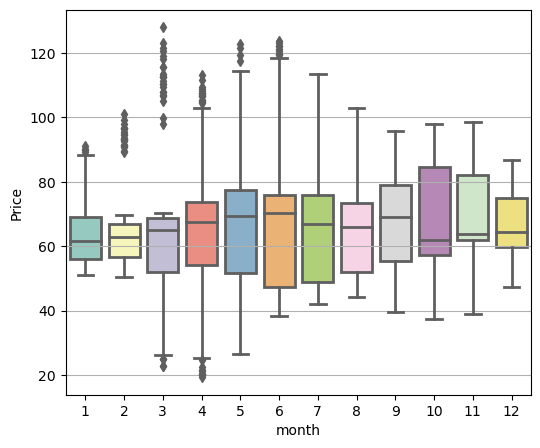

In [304]:
sns.boxplot(y='Price', x='month', data=df, palette='Set3')

### 연도별 가격 추이

<AxesSubplot:xlabel='year', ylabel='Price'>

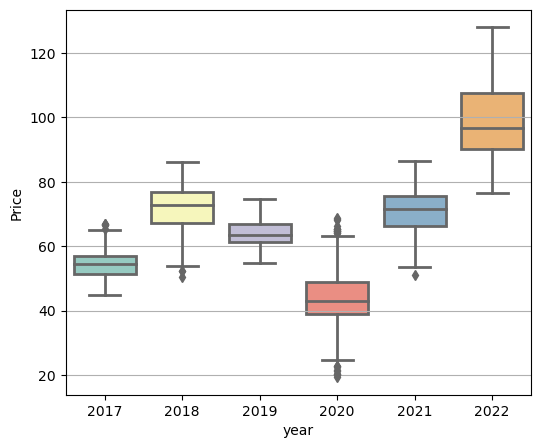

In [305]:
sns.boxplot(y='Price', x='year', data=df, palette='Set3')

## 3. 파생변수 생성

#### 일별 차이(Diff) 통한 증감 구하기

In [162]:
#이전 데이터와 다음 데이터의 차이 구하기
#df['Price'].diff()

df['Diff_Shift'] = df['Price'] - df['Price'].shift(1)
df.head(5)

,Date,Price,Open,High,Low,Vol.,Change %,ds,Vol,ChangePCT,Diff_Shift
0,12/01/2016,53.94,51.72,54.53,51.51,460.86K,6.88%,2016-12-01,460860.0,0.0688,NaN
1,12/02/2016,54.46,53.88,54.50,52.84,312.78K,0.96%,2016-12-02,312780.0,0.0096,0.52
2,12/05/2016,54.94,54.40,55.33,53.77,288.55K,0.88%,2016-12-05,288550.0,0.0088,0.48
3,12/06/2016,53.93,54.50,54.94,53.51,280.65K,-1.84%,2016-12-06,280650.0,-0.0184,-1.01
4,12/07/2016,53.00,53.94,54.23,52.92,298.57K,-1.72%,2016-12-07,298570.0,-0.0172,-0.93


#### 누적수익률 구하기

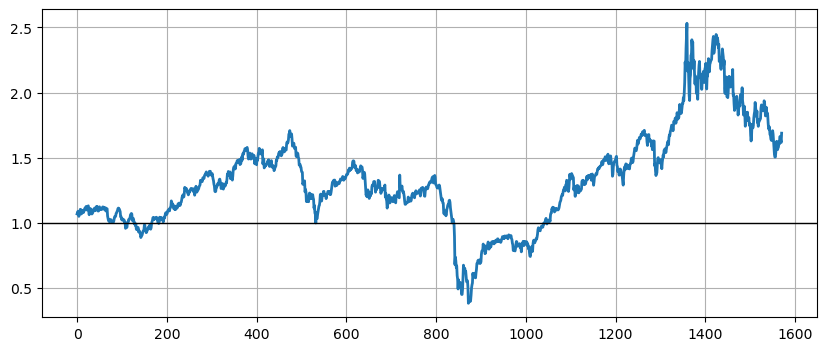

In [163]:
# 일별 수익률을 누적곱으로 구함 (시간이 지날수록 수익률은 덧셈이 아닌 곱셈으로 산출)
# ChangePCT = (종가 / 전일종가) - 1
# df['ChangePCT']+1하면 ??
cum_daily_return = (df['ChangePCT']+1).cumprod()
cum_daily_return.plot(figsize=(10,4))
plt.axhline(1, c="k", lw=1)

#### 단순이동평균(SMA) 구하기

In [164]:
# 윈도우7, 14 단순 이동평균 구하기
df['SMA7'] = df['Price'].rolling(7).mean()
df['SMA14'] = df['Price'].rolling(14).mean()

In [165]:
df

,Date,Price,Open,High,Low,Vol.,Change %,ds,Vol,ChangePCT,Diff_Shift,SMA7,SMA14
0,12/01/2016,53.94,51.72,54.53,51.51,460.86K,6.88%,2016-12-01,460860.0,0.0688,NaN,NaN,NaN
1,12/02/2016,54.46,53.88,54.50,52.84,312.78K,0.96%,2016-12-02,312780.0,0.0096,0.52,NaN,NaN
2,12/05/2016,54.94,54.40,55.33,53.77,288.55K,0.88%,2016-12-05,288550.0,0.0088,0.48,NaN,NaN
3,12/06/2016,53.93,54.50,54.94,53.51,280.65K,-1.84%,2016-12-06,280650.0,-0.0184,-1.01,NaN,NaN
4,12/07/2016,53.00,53.94,54.23,52.92,298.57K,-1.72%,2016-12-07,298570.0,-0.0172,-0.93,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1566,12/23/2022,84.50,82.32,84.70,81.83,180.40K,3.47%,2022-12-23,180400.0,0.0347,2.83,81.461429,80.187857
1567,12/27/2022,84.68,85.00,86.10,84.19,160.09K,0.21%,2022-12-27,160090.0,0.0021,0.18,81.941429,80.545714
1568,12/28/2022,83.26,84.60,84.76,81.92,57.56K,-1.68%,2022-12-28,57560.0,-0.0168,-1.42,82.480000,80.950714
1569,12/29/2022,82.26,82.88,83.14,81.28,10.99K,-1.20%,2022-12-29,10990.0,-0.0120,-1.00,82.782857,81.355714


<AxesSubplot:title={'center':'Simple Moving Average'}>

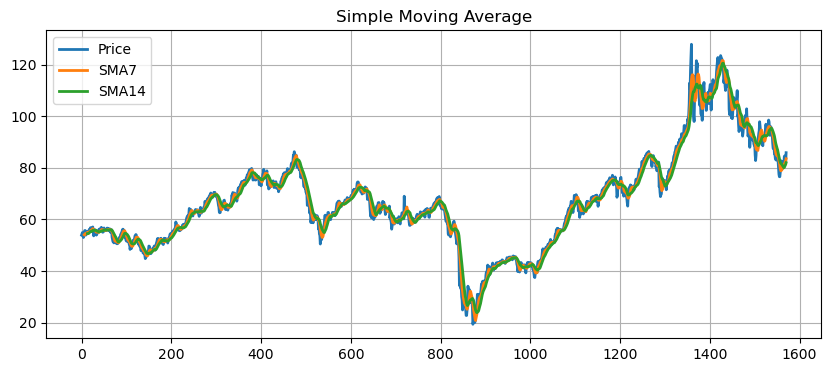

In [166]:
# 'Price','SMA7','SMA14' 시각화 하기
df[['Price','SMA7','SMA14']].plot(figsize=(10,4),title='Simple Moving Average')

#### 누적이동평균(CMA)구하기
* expanding을 사용, windown 창이 시간의 흐름에 따라 증가

In [167]:
#expanding을 사용
df['CMA'] = df['Price'].expanding(14).mean()

<AxesSubplot:title={'center':'Cumulative Moving Average'}>

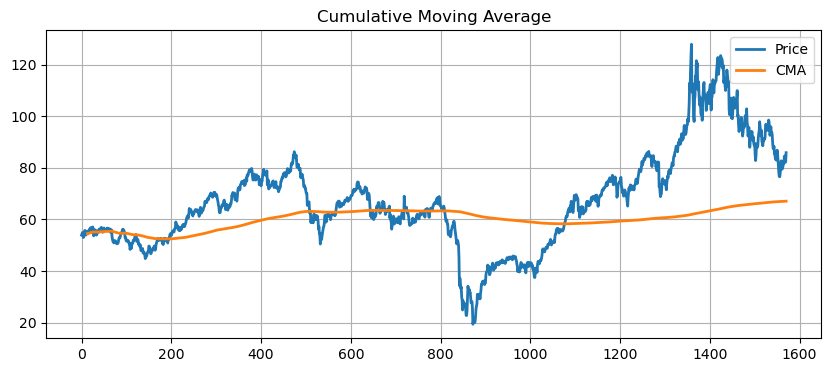

In [168]:
# CMA 시각화
df[['Price','CMA']].plot(figsize=(10,4),title='Cumulative Moving Average')

#### 지수이동평균(EMA) 구하기
* 최근 자료에 가중치를 부여하여 최근 가격 변동 나타냄

In [169]:
df["EWM_short"] = df["Price"].ewm(span=12).mean()
df["EWM_long"] = df["Price"].ewm(span=26).mean()

<AxesSubplot:title={'center':'Exponential Moving Average'}>

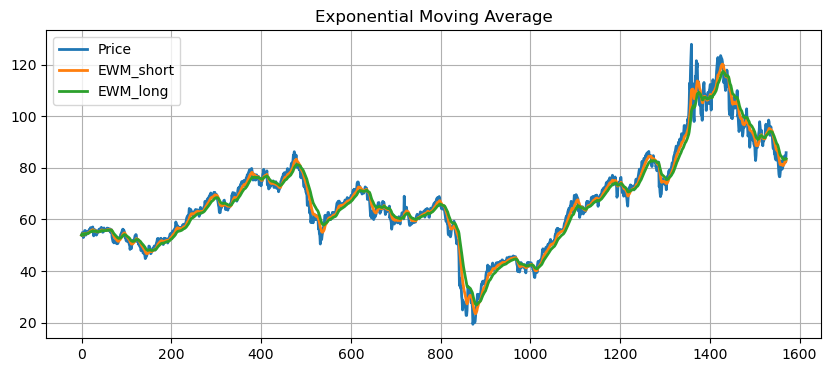

In [170]:
# "Price", "EWM_short", "EWM_long" 시각화
df[["Price", "EWM_short", "EWM_long"]].plot(figsize=(10, 4), 
                                            title="Exponential Moving Average")

In [172]:
df = df[df['ds'].between('2017-01-01','2022-12-31')]
df.sort_values(by=['ds'], inplace = True, ignore_index=True)
df.describe()

,Price,Open,High,Low,Vol,ChangePCT,Diff_Shift,SMA7,SMA14,CMA,EWM_short,EWM_long
count,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000
mean,67.264496,67.248165,68.320807,66.142435,249777.984496,0.000608,0.018792,67.210568,67.149701,60.188353,67.167507,67.036216
std,19.057615,19.031626,19.440002,18.616778,103437.028737,0.026080,1.710322,18.965249,18.885828,3.741372,18.848138,18.597836
min,19.330000,19.900000,21.290000,15.980000,5890.000000,-0.244000,-16.840000,20.780000,23.823571,52.444611,23.421810,26.892874
25%,55.447500,55.405000,56.027500,54.802500,198592.500000,-0.009800,-0.620000,55.483929,55.493036,58.368653,55.388655,55.307606
50%,65.215000,65.165000,66.045000,64.445000,257650.000000,0.002500,0.160000,65.244286,65.118929,60.557663,65.226353,64.992345
75%,76.195000,76.200000,77.005000,75.282500,308287.500000,0.012600,0.790000,76.044643,75.945357,63.206553,75.946424,76.028118
max,127.980000,130.280000,139.130000,122.500000,779720.000000,0.210200,8.800000,121.740000,120.616429,67.099222,120.291891,117.438328


#### 생성한 이동평균선 비교하기

<AxesSubplot:>

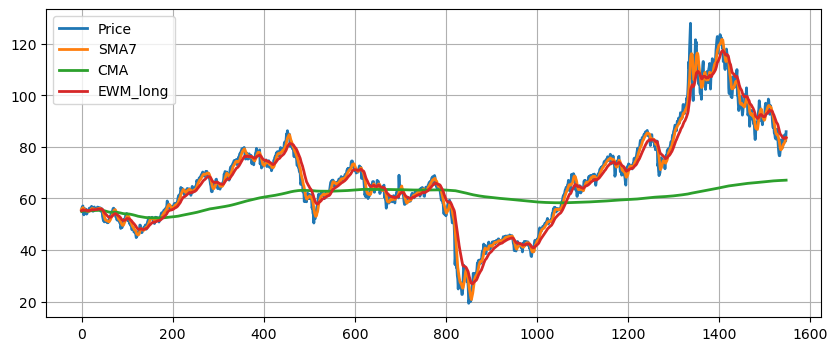

In [173]:
df[["Price", "SMA7", "CMA", "EWM_long"]].plot(figsize=(10, 4))

## 시각화

In [75]:
px.line(df, x='ds', y='Price', title='일별종가')

In [76]:
px.bar(df, x='ds', y='Vol', title='거래량')

In [77]:
px.histogram(df, x='Vol')

## Modeling

In [49]:
#train에 필요한 column만 가지고 오기
train = df[['ds', 'Price','Vol.']]
train.head()

,ds,Price,Vol.
0,2015-01-02,56.42,177.98K
1,2017-01-02,56.82,NaN
2,2018-01-02,66.57,211.74K
3,2019-01-02,54.91,300.95K
4,2020-01-02,66.25,205.69K
